# Определение возраста по фотографии (версия с PyTorch)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Convolutional_Neural_Network_with_Color_Image_Filter.gif/640px-Convolutional_Neural_Network_with_Color_Image_Filter.gif 'Cecbur')

Задача: построить модель, которая по фотографии человека могла бы предсказывать его возраст. Для обучения будем использовать набор данных [APPA-REAL](https://chalearnlap.cvc.uab.es/dataset/26/description/).

## Загрузка и ознакомление с данными

In [1]:
! pip install pytorch_lightning --quiet

     |████████████████████████████████| 708 kB 5.1 MB/s 
     |████████████████████████████████| 529 kB 55.6 MB/s 


In [2]:
! gdown 1wJ5ILDZAbMHWgDyVnWBjqyu0e7RiWZKs

Downloading...
From: https://drive.google.com/uc?id=1wJ5ILDZAbMHWgDyVnWBjqyu0e7RiWZKs
To: /content/appa-real-release.zip
100% 885M/885M [00:07<00:00, 126MB/s]


In [3]:
! unzip -uq appa-real-release.zip

In [4]:
import os

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import pytorch_lightning as pl

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import Adam

from torchvision import transforms
from torchvision import models
from torchvision.io import read_image 
from torch.optim.lr_scheduler import StepLR


from torchmetrics.functional import mean_absolute_error

In [5]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 9)})

В имеющемся у нас наборе содержится 7591 фотография. Для каждой фотографии известен реальный возраст человека и несколько оценок. Для нашего проекта будем использовать только реальный возраст.

In [6]:
df_train = pd.read_csv('/content/appa-real-release/gt_train.csv')

In [7]:
df_val = pd.read_csv('/content/appa-real-release/gt_valid.csv')

In [8]:
df_test = pd.read_csv('/content/appa-real-release/gt_test.csv')

Посмотрим на данные.

In [9]:
df_train.head(10)

file_name  real_age  apparent_age  worker_age worker_gender
0  000000.jpg         4             5          36          male
1  000000.jpg         4             4          38        female
2  000000.jpg         4             7          52        female
3  000000.jpg         4             5          50          male
4  000000.jpg         4             4          52        female
5  000000.jpg         4             5          33        female
6  000000.jpg         4             5          38          male
7  000000.jpg         4             6          24          male
8  000000.jpg         4             7          42        female
9  000000.jpg         4             6          28        female

В колонках представлена следующая информация:
* `file_name` — имя файла с фотографией,
* `real_age` — реальный возраст человека на фотографии,
* `apparent_age` — оценка возраста другим человеком,
* `worker_age` — возраст человека, производившего оценку,
* `worker_gender` — пол человека, производившего оценку.

Видно, что для каждой фотографии приведены несколько оценок возрастов. Нам интересны только первые две колонки.

In [10]:
df_train = df_train.drop(['apparent_age', 
                          'worker_age', 
                          'worker_gender'], axis=1)

In [11]:
df_train = df_train.drop_duplicates()

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4113 entries, 0 to 133867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.4+ KB


Прекрасно! Данные мы обработали, дубликаты отбросили, пропусков данных нет. Посмотрим на распределение возраста.

### `real_age`

In [13]:
df_train.real_age.describe().to_frame()

real_age
count  4113.000000
mean     30.476052
std      16.312428
min       1.000000
25%      19.000000
50%      28.000000
75%      40.000000
max     100.000000

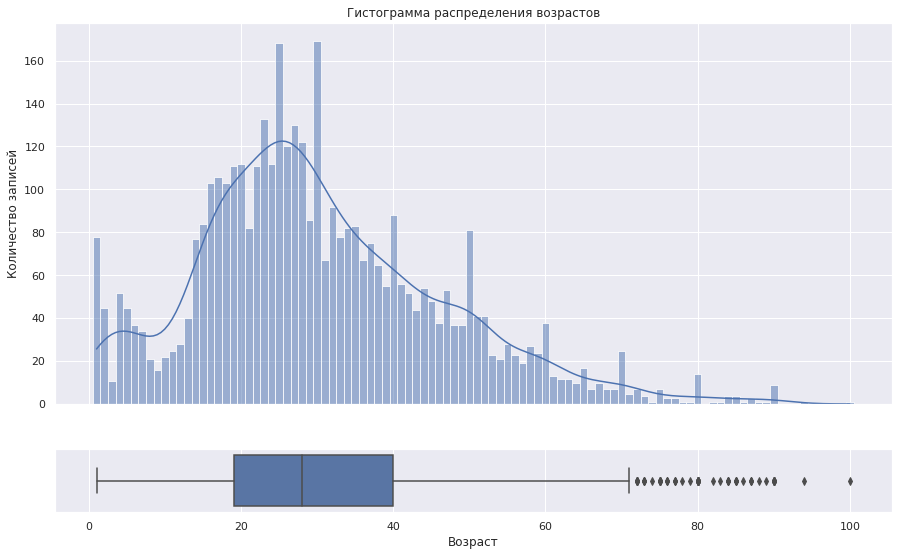

In [14]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[6,1]))
sns.histplot(data=df_train, x='real_age', discrete=True,
             kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения возрастов',
     ylabel='Количество записей')
sns.boxplot(data=df_train, x='real_age', ax=axs_box)\
.set(xlabel='Возраст');

Гистограмма выглядит правдоподобно. Возраст людей на фото начинается от одного года, меньше всего фотографий людей моложе 10 лет и старше 60 лет. Нижний и верхний квантили приходятся на возраста от 19 до 40 лет. Видны ярковыраженные пики в районе «круглых» возрастов, возможно при заполнении этой колонки данные о возрасте для некоторых фотографий округлялись.

Убедимся, что возраст людей на фотографиях размечен правильно. Посмотрим на фотографии людей старше 90 лет.

In [15]:
seniors = df_train[df_train['real_age'] >= 90].sample(5, random_state=42)

Age: 90


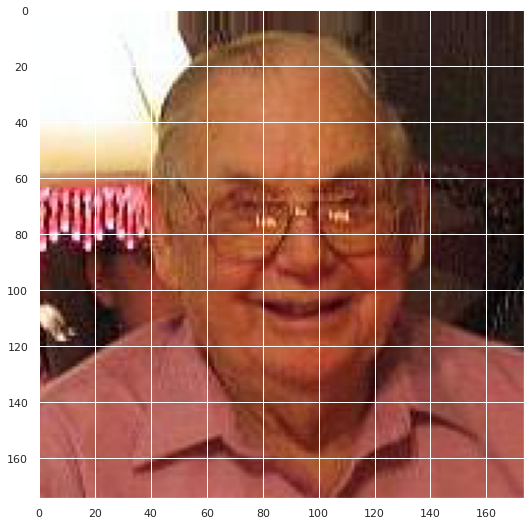

Age: 90


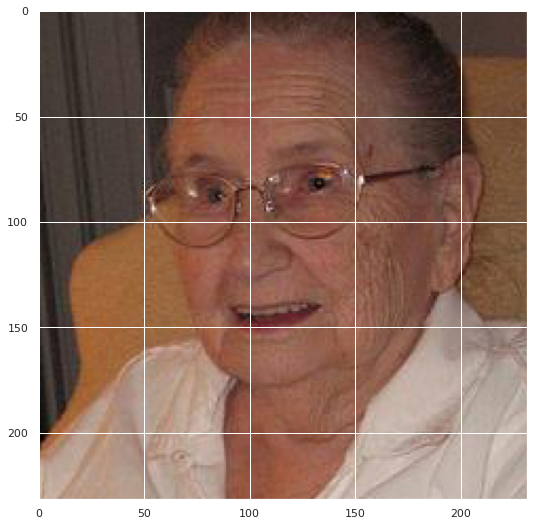

Age: 100


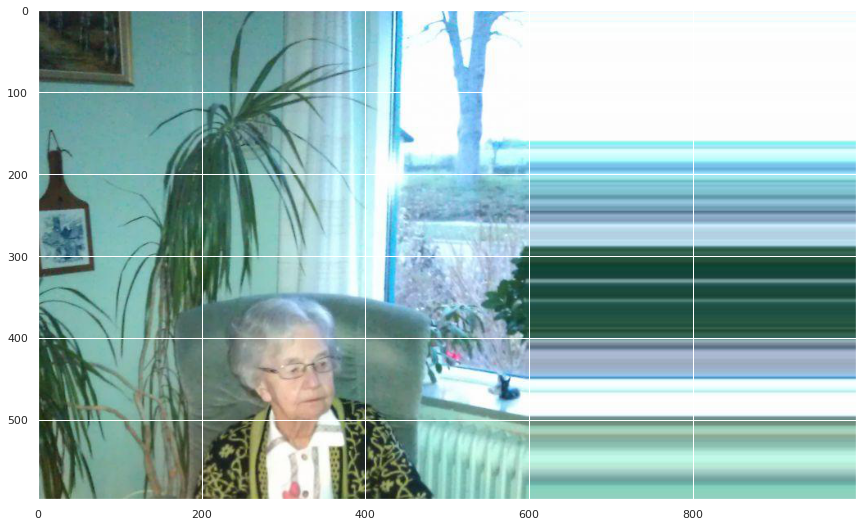

Age: 90


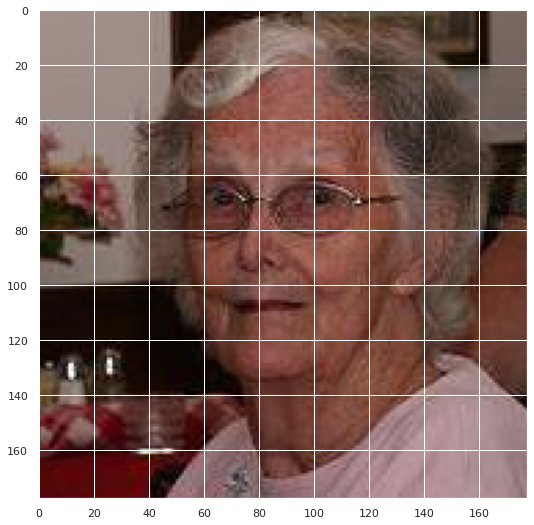

Age: 94


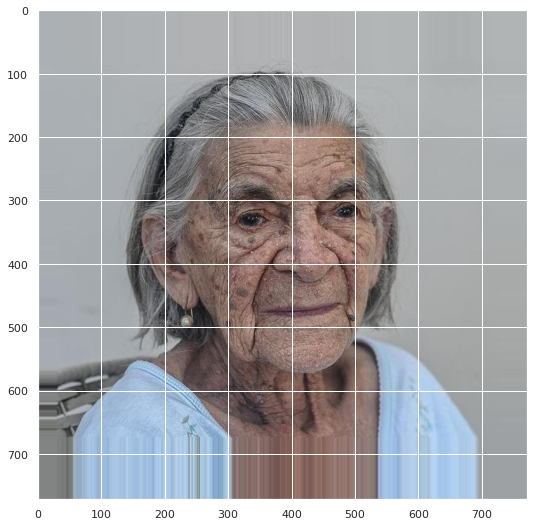

In [16]:
for _, row in seniors.sample(5, random_state=42).iterrows():
    file_name = row['file_name'] + '_face.jpg'
    print('Age:', row['real_age'])
    image = Image.open('/content/appa-real-release/train/' +
                      file_name)
    plt.imshow(image)
    plt.show()

Похоже, что эти фотографии размечены правильно. Теперь посмотрим на фотографии людей возрастом до 5 лет.

In [17]:
juniors = df_train[df_train['real_age'] < 5]

Age: 2


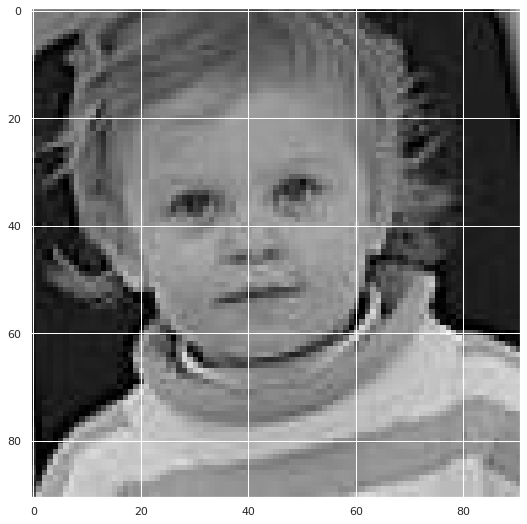

Age: 4


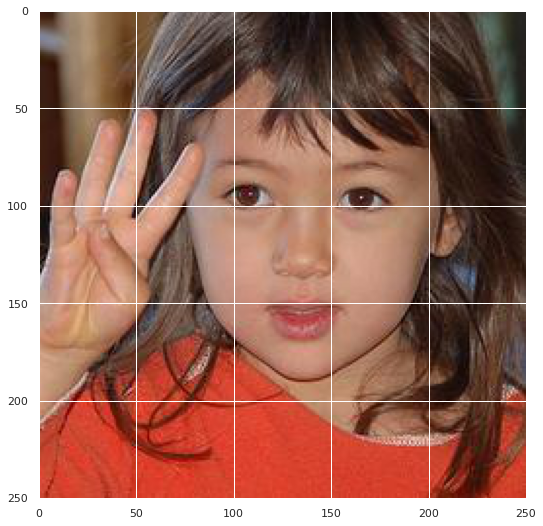

Age: 4


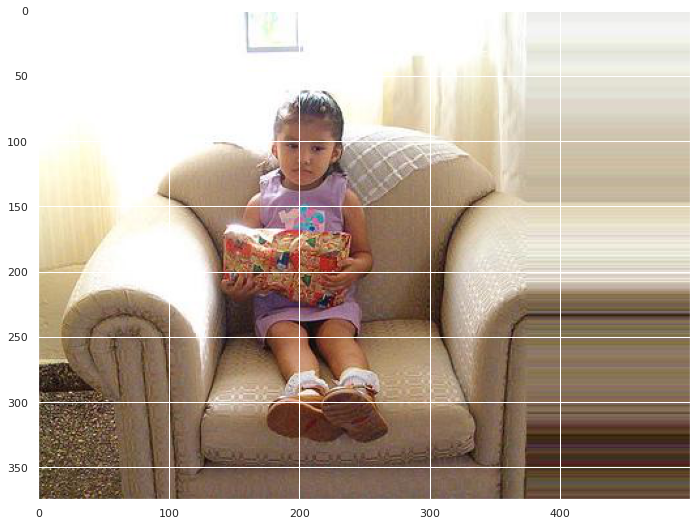

Age: 1


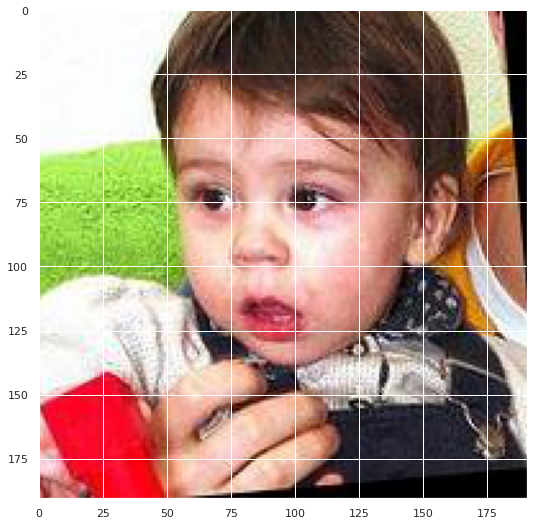

Age: 1


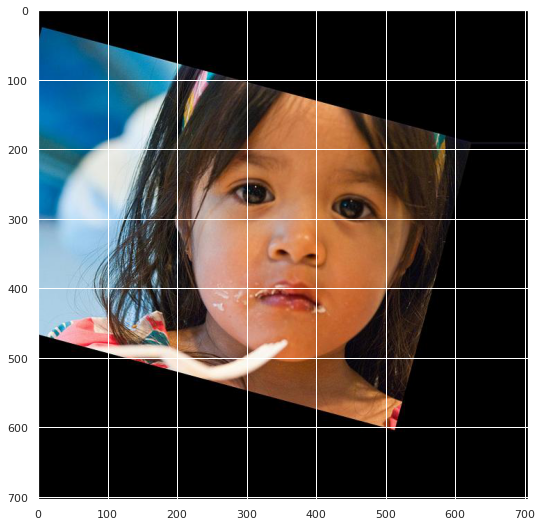

In [18]:
for _, row in juniors.sample(5, random_state=42).iterrows():
    file_name = row['file_name'] + '_face.jpg'
    print('Age:', row['real_age'])
    image = Image.open('/content/appa-real-release/train/' +
                      file_name)
    plt.imshow(image)
    plt.show()

Чтож, и здесь проблем не видно. Дети как дети, на свой возраст они и выглядят. Видно, что к некоторым фотографиям применялись аугментации.

**Вывод**

В нашем распоряжении наборы фотографий, а также таблицы, в которых указан возраст человека на фотографии. Мы провели небольшое исследование данных. В учебной таблице содержатся записи о 4113 фотографиях. Средний возраст людей на них — 30 лет, медианный возраст — 28 лет. Есть фотографии людей с возрастом 1 год и 100 лет.

При выводе 10 случайных фотографий с людей с возрастами старше 90 лет и моложе 5 лет мы не обнаружили фотографий с некорректно размеченным возрастом. Видно, что фотографии имеют разное разрешение, но при обучении их надо будет привести к одному формату. Также видно, что фотографии сделаны под разными углами, видимо ранее с ними уже была произведена аугментация и при обучении модели этот шаг можно будет упростить.

В целом можно заключить, что данные готовы для обучения модели и дополнительная обработка не требуется.

## Подготовка данных

Для подготовки данных к обучению нам нужно оставить только информацию о названии файла и реальном возрасте людей на фотографиях.

In [19]:
df_test = df_test.drop(['apparent_age', 
                          'worker_age', 
                          'worker_gender'], axis=1)

In [20]:
df_val = df_val.drop(['apparent_age', 
                          'worker_age', 
                          'worker_gender'], axis=1)

In [21]:
df_test = df_test.drop_duplicates()
df_val = df_val.drop_duplicates()

Фотографии лиц хранятся в файлах `*_face.jpg`, оставим только их и обновим информацию в таблицах.

In [22]:
! mkdir /content/test
! mkdir /content/train
! mkdir /content/val

In [23]:
! cp /content/appa-real-release/test/*_face.jpg /content/test
! cp /content/appa-real-release/train/*_face.jpg /content/train
! cp /content/appa-real-release/valid/*_face.jpg /content/val

In [24]:
! rm -rf appa-real-release/

In [25]:
df_train['file_name'] = df_train['file_name'] + '_face.jpg'

In [26]:
df_test['file_name'] = df_test['file_name'] + '_face.jpg'

In [27]:
df_val['file_name'] = df_val['file_name'] + '_face.jpg'

In [28]:
df_train.head()

file_name  real_age
0    000000.jpg_face.jpg         4
36   000001.jpg_face.jpg        18
99   000002.jpg_face.jpg        80
137  000003.jpg_face.jpg        50
175  000004.jpg_face.jpg        17

Для улучшения обучения добавим аугментации. Будем обрезать фотографии до размера 256 на 256 пикселей (как в датасете ImageNet), а также добавим горизонтальное отражение и нормализацию.

In [29]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
}

Для передачи данных нейронной сети обернём их в класс Dataset, который затем передадим в DataLoader.

In [30]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1].astype('float32')
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [31]:
train_dataset = CustomImageDataset(df_train,
                                   '/content/train/',
                                   data_transforms['train'])

In [32]:
val_dataset = CustomImageDataset(df_val, '/content/val/',
                                 data_transforms['val'])

In [33]:
test_dataset = CustomImageDataset(df_test, '/content/test/',
                                  data_transforms['val'])

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=32, 
                              shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, 
                            shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, 
                             shuffle=False, pin_memory=True)

Отлично. Теперь всё готово для обучения нейронной сети.

## Обучение модели

Создадим нейросеть ResNet50. Эта нейросеть обучалась для решения задачи классификации на наборе данных ImageNet. Чтобы адаптировать её под наши задачи нужно заменить ей "голову" и функцию потерь. Затем мы "заморозим" основные слои нейронной сети и проведём несколько эпох обучения.

In [35]:
class AgeRegressor(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss = nn.MSELoss()
        
        self.pretrain_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.pretrain_model.eval()
        for name, param in self.pretrain_model.named_parameters():
            if ('bn' not in name):
                param.requires_grad = False

        self.pretrain_model.fc = nn.Linear(self.pretrain_model.fc.in_features, 
                                           1)

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        outputs = outputs.view(-1)
        train_mae = mean_absolute_error(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_mae', train_mae, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, 'train_mae': train_mae}

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        outputs = outputs.view(-1)
        valid_mae = mean_absolute_error(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('valid_mae', valid_mae, prog_bar=True)
        self.log('val_loss', loss)
        return {"loss": loss, 'valid_mae': valid_mae}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        outputs = outputs.view(-1)
        test_mae = mean_absolute_error(outputs, targets)
        loss = self.loss(outputs, targets)
        
        return {"test_loss": loss, "test_mae": test_mae,
                'test_pred': outputs, 'test_target': targets}
    
    def test_epoch_end(self, outputs):
        test_mae = []
        test_pred = []
        test_targ = []
        for test_out in outputs:
            mae = test_out['test_mae']
            test_mae.append(mae)

            pred = test_out['test_pred']
            test_pred += pred.tolist()

            targ = test_out['test_target']
            test_targ += targ.tolist()
        total_test_mae = torch.stack(test_mae).mean()

        sns.set(rc={'figure.figsize': (15, 15)})
        sns.scatterplot(x=test_targ, 
                        y=test_pred)\
        .set(xlabel='Реальный возраст',
        ylabel='Предсказанный возраст',
        title='Оценка предсказаний модели')
        sns.lineplot(x=test_targ, 
                     y=test_targ, 
                     color='black');

        self.log('total_test_mae', total_test_mae, on_step=False, on_epoch=True)
        return total_test_mae

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = Adam(params=params, lr = self.learning_rate)
        scheduler = StepLR(optimizer, step_size=10, verbose=False)
        return [optimizer], [scheduler]


In [36]:
model = AgeRegressor()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Подберём для нашей задачи learning rate.

In [37]:
trainer = pl.Trainer(auto_lr_find=True, accelerator='cuda')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [38]:
lr_finder = trainer.tuner.lr_find(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_129b4f14-e44f-4fb4-bf99-78c32d358506.ckpt


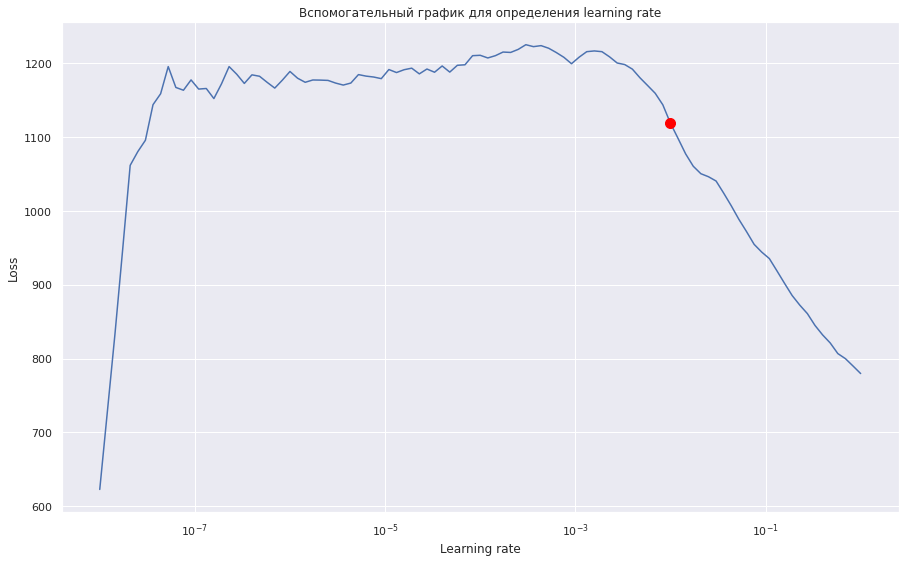

In [39]:
plot = lr_finder.plot(suggest=True)
plt.title('Вспомогательный график для определения learning rate')
plot.show()

In [40]:
lr_finder.suggestion()

0.01

In [41]:
model.learning_rate = lr_finder.suggestion()

In [42]:
trainer.fit(model, train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type    | Params
-------------------------------------------
0 | loss           | MSELoss | 0     
1 | pretrain_model | ResNet  | 23.5 M
-------------------------------------------
47.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


На валидационной выборке средняя абсолютная ошибка снизилась примерно до 7 лет. Неплохо. Посмотрим на тестовые данные.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     total_test_mae          8.25540542602539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'total_test_mae': 8.25540542602539}]

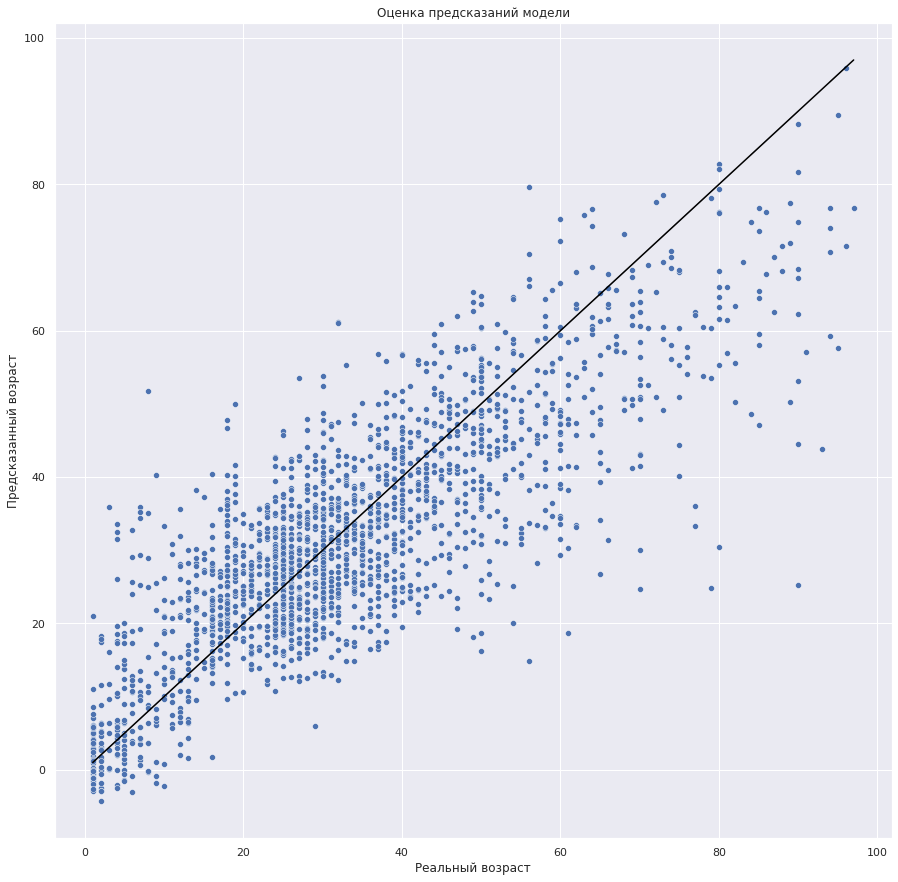

In [43]:
trainer.test(model, test_dataloader)

На тестовой выборке средняя абсолютная ошибка превышает восемь лет. На графике видно, что основной вклад в ошибку вносят фотографии людей старше 60 лет, так как именно таких фотографий мало в обучающей выборке. 

Попробуем улучшить наш результат. Разморозим последние слои ResNet и проведём ещё несколько эпох обучения.

In [44]:
for name, param in model.pretrain_model.named_parameters():
    if ('layer4' in name):
        param.requires_grad = True

In [45]:
trainer.fit(model, train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type    | Params
-------------------------------------------
0 | loss           | MSELoss | 0     
1 | pretrain_model | ResNet  | 23.5 M
-------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 8it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Нам удалось снизить среднюю абсолютную ошибку на валидации почти на год. Очень неплохо. Посмотрим на результаты на тестовой выборке.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     total_test_mae          7.482702255249023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'total_test_mae': 7.482702255249023}]

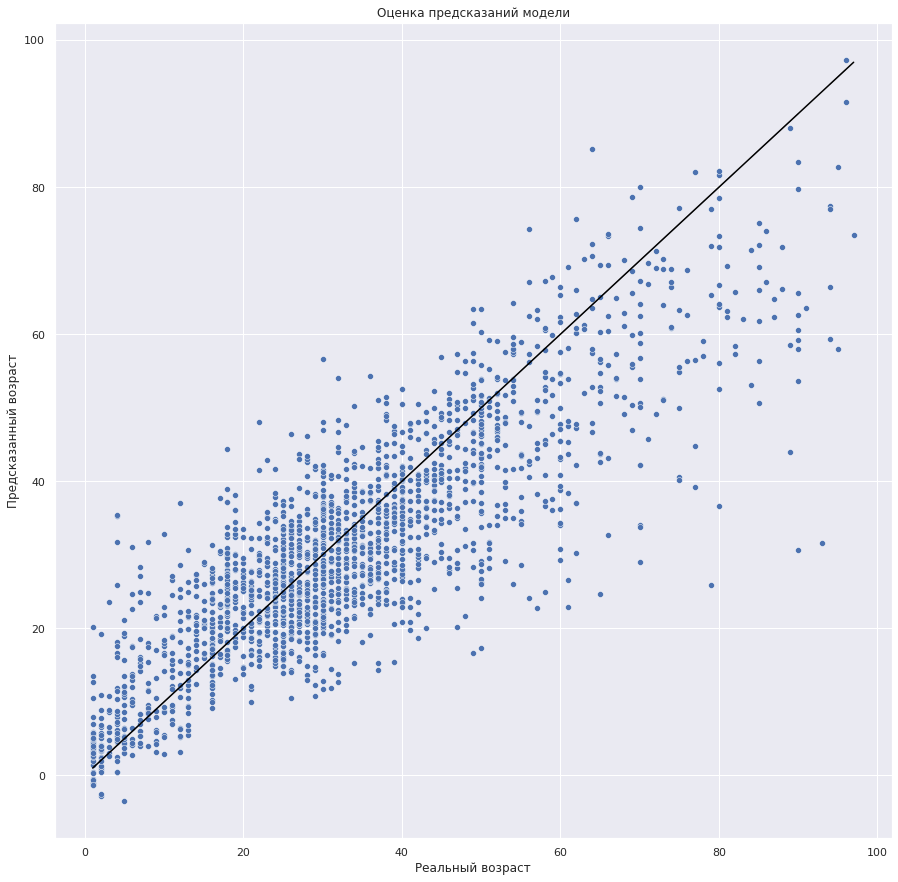

In [46]:
trainer.test(model, test_dataloader)

На тестовой выборке ошибка тоже снизилась. На построенном графике видно, что для людей среднего возраста ошибка стала ещё меньше.

Сохраним обученную модель.

In [48]:
torch.save(model, 'age.pt')

# Вывод

Мы построили модель определения возраста по фотографии. Для обучения мы применили библиотеки pytorch и Lightning, нейросеть ResNet50, предобученную на наборе ImageNet.

В нашем распоряжении наборы фотографий, а также таблицы, в которых указан возраст человека на фотографии. Мы провели небольшое исследование данных. В учебной таблице содержатся записи о 4113 фотографиях. Средний возраст людей на них — 30 лет, медианный возраст — 28 лет. Есть фотографии людей с возрастом 1 год и 100 лет.

При выводе 10 случайных фотографий с людей с возрастами старше 90 лет и моложе 5 лет мы не обнаружили фотографий с некорректно размеченным возрастом.

Затем данные были подготовлены для обучения. Из всего набора файлов мы выделили файлы с лицами, загрузили их в класс DataSet, а затем передали его в класс DataLoader.

Для обучения была создана нейросеть ResNet50. Эта нейросеть обучалась для решения задачи классификации на наборе данных ImageNet. Чтобы адаптировать её под наши задачи мы заменили ей "голову" и функцию потерь. Затем "заморозили" основные слои нейронной сети и провели несколько эпох обучения.

В результате предварительного обучения средняя абсолютная ошибка на валидационных данных снизилась почти до семи лет, а на тестовых — до восьми.

Чтобы улучшить данный результат мы разморозили несколько последних слоёв сети ResNet и продолжили обучение.

Таким образом удалось снизить среднюю абсолютную ошибку на валидации почти до шести лет, а на тесте — до семи.

При этом на построенных графиках видно, что основной вклад в ошибку вносят фотографии людей старше 60 лет, так их мало в обучающем наборе данных. При получении дополнительных фотографий можно ожидать улучшения качества модели. 